In [ ]:
import numpy as np 
import pandas as pd 
from sklearn.utils.multiclass import unique_labels


import os

In [ ]:
#Import standard libraries

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
#Import keras functions

from keras import Sequential
from keras.applications import VGG19,ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.utils import to_categorical

Using TensorFlow backend.


In [ ]:
#Import dataset
from keras.datasets import cifar10

In [ ]:
#Membagi data dalam Train, Validation dan Test Datasets
(x_train,y_train),(x_test,y_test)=cifar10.load_data()



170500096/170498071 [==============================] - 4s 0us/step


In [ ]:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.3)

In [ ]:
#Cetak dimensi kumpulan data untuk memastikan semuanya berjalan dengan lancar

print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 1))
((15000, 32, 32, 3), (15000, 1))
((10000, 32, 32, 3), (10000, 1))


In [ ]:
#One hot encode the labels. Karena kita memiliki 10 kelas, kita harus mengharapkan bentuk [1] dari y_train,y_val dan y_test berubah dari 1 menjadi 10

y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)


In [ ]:
# Cetak dimensi untuk melihat apakah ada yang berubah seperti yang kita harapkan

print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 10))
((15000, 32, 32, 3), (15000, 10))
((10000, 32, 32, 3), (10000, 10))


In [ ]:
#Data Augmentation Function: Definisikan instance kelas ImageDataGenerator dan atur parameternya. Untuk membuat instance untuk dataset Train, Validation, dan Test
train_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip=True,
                                    zoom_range=.1 )

val_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip=True,
                                    zoom_range=.1)

test_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip= True,
                                    zoom_range=.1) 




In [ ]:
#Sesuaikan metode augmentasi dengan data

train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

In [ ]:
lrr= ReduceLROnPlateau(
                       monitor='val_acc', #Metric yang akan diukur
                       factor=.01, #Factor dimana tingkat pembelejaran akan dikurangi
                       patience=3,  #Jumlah epoch setelahnya jika tidak ada peningkatan pada val_acc, tingkat pembelajaran berkurang
                       min_lr=1e-5) #Minimum learning rate 

In [ ]:
#pembuatan model

'model yang pertama digunakan adalah VGG19'
base_model_1 = VGG19(include_top=False,weights='imagenet',input_shape=(32,32,3),classes=y_train.shape[1])

'model dasar ke-2 kami akan menggunakan Resnet 50 dan membandingkan kinerjanya dengan yang sebelumnya. Hipotesisnya adalah bahwa Resnet 50 harus bekerja lebih baik karena arsitekturnya yang lebih dalam'
base_model_2 = ResNet50(include_top=False,weights='imagenet',input_shape=(32,32,3),classes=y_train.shape[1])

Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 2s 0us/step


/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step


In [ ]:
#Mari tambahkan lapisan terakhir ke model dasar ini di mana klasifikasi sebenarnya dilakukan di dense layers

model_1= Sequential()
model_1.add(base_model_1) #Menambahkan model dasar (dalam hal ini vgg19 ke model_1)
model_1.add(Flatten())

Before we add the dense layers we must know the shape of the output of the flatten layer so we can define the input shape to the dense layer accordingly. The way I handle is I print the summary of the model after the flatten layer is added. 

In [ ]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
Total params: 20,024,384
Trainable params: 20,024,384
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#tambahkan Dense layers dengan activation dan batch normalization
model_1.add(Dense(1024,activation=('relu'),input_dim=512))
model_1.add(Dense(512,activation=('relu'))) 
model_1.add(Dense(256,activation=('relu'))) 
#model_1.add(Dropout(.3))#Menambahkan lapisan dropout yang akan menjatuhkan 30% bobot secara acak
model_1.add(Dense(128,activation=('relu')))
#model_1.add(Dropout(.2))
model_1.add(Dense(10,activation=('softmax'))) #Ini adalah lapisan klasifikasi


In [ ]:
#Check final model summary
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total para

In [ ]:
batch_size= 100
epochs=50

In [ ]:
learn_rate=.001

sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


In [ ]:
#Kompilasi modelnya
#Selama kompilasi model, 3 hal utama yang kami tentukan adalah fungsi kerugian, pengoptimal, dan metrik yang perlu dievaluasi selama proses pengujian dan pelatihan.
#Mari kita mulai dengan menggunakan pengoptimal SGD
model_1.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])


In [ ]:
model_1.fit_generator(train_generator.flow(x_train,y_train,batch_size=batch_size),
                      epochs=epochs,
                      steps_per_epoch=x_train.shape[0]//batch_size,
                      validation_data=val_generator.flow(x_val,y_val,batch_size=batch_size),validation_steps=250,
                      callbacks=[lrr],verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
350/350 [==============================] - 33s 94ms/step - loss: 1.6679 - acc: 0.3787 - val_loss: 1.0736 - val_acc: 0.6371
Epoch 2/50
350/350 [==============================] - 28s 81ms/step - loss: 0.9357 - acc: 0.6769 - val_loss: 0.8932 - val_acc: 0.6983
Epoch 3/50
350/350 [==============================] - 28s 81ms/step - loss: 0.7284 - acc: 0.7501 - val_loss: 0.7943 - val_acc: 0.7282
Epoch 4/50
350/350 [==============================] - 28s 81ms/step - loss: 0.6289 - acc: 0.7876 - val_loss: 0.6672 - val_acc: 0.7752
Epoch 5/50
350/350 [==============================] - 28s 81ms/step - loss: 0.5397 - acc: 0.8126 - val_loss: 0.6133 - val_acc: 0.7927
Epoch 6/50
350/350 [==============================] - 28s 81ms/step - loss: 0.4835 - acc: 0.8333 - val_loss: 0.5586 - val_acc: 0.8114
Epoch 7/50
350/350 [==============================] - 29s 82ms/step - loss: 0.4281 - acc: 0.8534 - val_loss: 0.5266 - val_acc: 0.8227
Epoch 8/50
350

1. Let's now begin to evaluate our model.

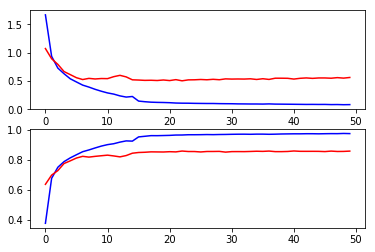

In [ ]:
#Plot the training and valiation loss

f,ax=plt.subplots(2,1) #Membuat 2 subplot di bawah 1 kolom

#Tetapkan subplot pertama ke grafik  training loss and validation loss
ax[0].plot(model_1.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model_1.history.history['val_loss'],color='r',label='Validation Loss')

#Selanjutnya mari kita plot akurasi pelatihan dan akurasi validasi
ax[1].plot(model_1.history.history['acc'],color='b',label='Training  Accuracy')
ax[1].plot(model_1.history.history['val_acc'],color='r',label='Validation Accuracy')

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Menghitung confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # Kami ingin menampilkan semua tanda centang...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... dan beri label dengan entri daftar masing-masing
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Putar label centang dan atur perataannya.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Ulangi dimensi data dan buat anotasi teks.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

Sekarang setelah kita memiliki kode untuk confusion matrix, mari buat prediksi pada set pengujian dan lihat bagaimana kinerja model ini

In [ ]:
y_pred=model_1.predict_classes(x_test)
y_true=np.argmax(y_test,axis=1)

#menghitung confusion matrix
confusion_mtx=confusion_matrix(y_true,y_pred)


In [ ]:
class_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Confusion matrix, without normalization


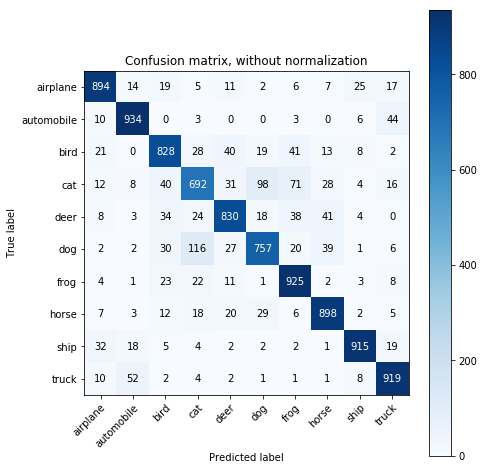

In [ ]:
# Plot confusion matrix yang tidak dinormalisasikan
plot_confusion_matrix(y_true, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')


Normalized confusion matrix


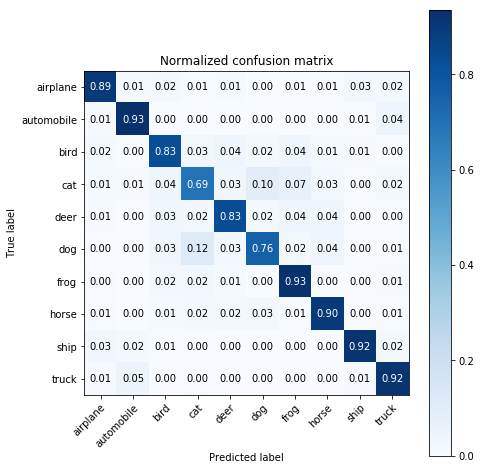

In [ ]:
# Plot confusion matrix yang di normalisasikan
plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
# plt.show()

Analysis Of Results: 
melihat Normalized Confusion Matrix, kami melihat bahwa secara keseluruhan, model tersebut telah bekerja dengan baik, kecuali dalam kasus kucing. Model tersebut tampaknya salah mengklasifikasikan kucing dan anjing satu sama lain.

In [ ]:
#Karena kita telah mendefinisikan Resnet50 sebagai base_model_2, mari kita buat model berurutannya.

model_2=Sequential()
#Tambahkan Dense layers bersama dengan aktivasi dan normalisasi batch
model_2.add(base_model_2)
model_2.add(Flatten())


#Tambahkan Dense layers bersama dengan aktivasi dan normalisasi batch
model_2.add(Dense(4000,activation=('relu'),input_dim=512))
model_2.add(Dense(2000,activation=('relu'))) 
model_2.add(Dropout(.4))
model_2.add(Dense(1000,activation=('relu'))) 
model_2.add(Dropout(.3))#Menambahkan lapisan dropout yang akan menjatuhkan 30% bobot secara acak
model_2.add(Dense(500,activation=('relu')))
model_2.add(Dropout(.2))
model_2.add(Dense(10,activation=('softmax'))) #Ini adalah lapisan klasifikasi

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 4000)              8196000   
_________________________________________________________________
dense_7 (Dense)              (None, 2000)              8002000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2000)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1000)              2001000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000)              0         
__________

Segera perbedaan pertama yang kami lihat adalah bahwa ResNet50 memiliki lebih dari 16 juta parameter tambahan untuk dilatih yang diharapkan karena ini adalah model yang lebih dalam. Selain itu, jumlah unit sebelum layer Flatten adalah 4 kali lipat dari model sebelumnya.

In [ ]:
#Compile the model 

model_2.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model_2.fit_generator(train_generator.flow(x_train,y_train,batch_size=batch_size),
                     epochs=50,steps_per_epoch=x_train.shape[0]//batch_size,
                     validation_data=val_generator.flow(x_val,y_val,batch_size=batch_size),validation_steps=250,
                      callbacks=[lrr],verbose=1)

Epoch 1/50
350/350 [==============================] - 42s 120ms/step - loss: 1.2157 - acc: 0.5835 - val_loss: 1.5938 - val_acc: 0.4472
Epoch 2/50
350/350 [==============================] - 42s 121ms/step - loss: 1.3789 - acc: 0.5203 - val_loss: 1.4919 - val_acc: 0.4736
Epoch 3/50
350/350 [==============================] - 42s 120ms/step - loss: 1.1851 - acc: 0.5906 - val_loss: 1.6127 - val_acc: 0.5940
Epoch 4/50
350/350 [==============================] - 42s 120ms/step - loss: 1.1490 - acc: 0.6137 - val_loss: 1.2727 - val_acc: 0.5646
Epoch 5/50
350/350 [==============================] - 43s 123ms/step - loss: 0.9968 - acc: 0.6657 - val_loss: 1.1632 - val_acc: 0.6215
Epoch 6/50
350/350 [==============================] - 42s 121ms/step - loss: 0.9666 - acc: 0.6777 - val_loss: 1.2499 - val_acc: 0.6344
Epoch 7/50
350/350 [==============================] - 43s 122ms/step - loss: 0.9664 - acc: 0.6803 - val_loss: 0.9643 - val_acc: 0.6732
Epoch 8/50
350/350 [==============================] - 4

Akurasi validasi telah stabil di sekitar 75%. Mari plot training Pelatihan Vs Validasi untuk melihat apakah overfitting telah terjadi.

In [ ]:
f,ax=plt.subplots(2,1) #Membuat 2 subplot di bawah 1 kolom

#Tetapkan subplot pertama ke grafik kerugian pelatihan dan kerugian validasi
ax[0].plot(model_2.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model_2.history.history['val_loss'],color='r',label='Validation Loss')

#Selanjutnya mari kita plot akurasi pelatihan dan akurasi validasi
ax[1].plot(model_2.history.history['acc'],color='b',label='Training  Accuracy')
ax[1].plot(model_2.history.history['val_acc'],color='r',label='Validation Accuracy')

Model ini mulai melakukan overfitting sekitar 80 epoch di mana kami menemukan bahwa akurasi validasi tetap sama, namun akurasi pelatihan terus meningkat. Akurasi validasi saat ini sekitar 74%. Dibandingkan dengan model sebelumnya, kinerja model ini tidak sebaik itu. Pada titik overfitting model sebelumnya memiliki akurasi validasi sebesar 78%. JIKA hipotesis ini benar, maka kita harus melihat hasilnya dalam confusion matrix. Jadi mari kita plot mereka sekarang

In [ ]:
y_pred_resnet=model_2.predict_classes(x_test)
y_true=np.argmax(y_test,axis=1)

#menghitung confusion matrix
confusion_mtx=confusion_matrix(y_true,y_pred_resnet)

Confusion matrix, without normalization


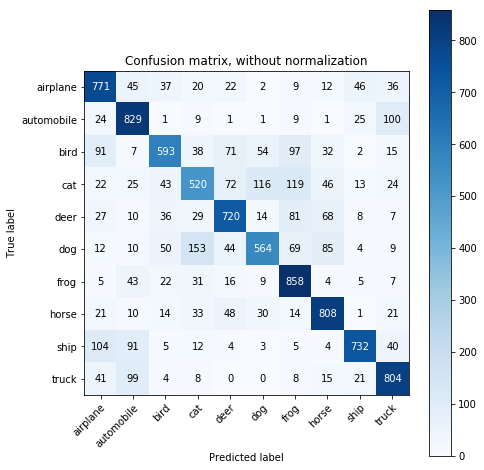

In [ ]:
# Plot matriks kebingungan yang tidak dinormalisasi
plot_confusion_matrix(y_true, y_pred_resnet, classes=class_names,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix


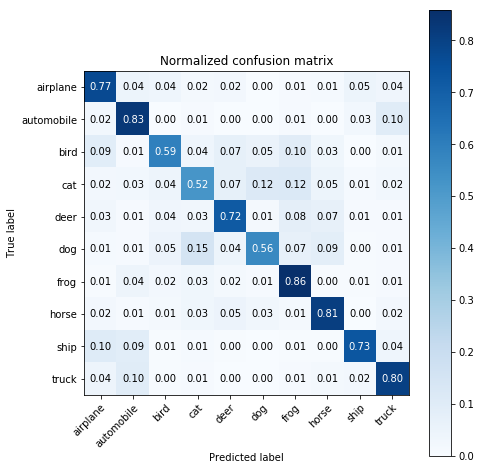

In [ ]:
# Plot matriks kebingungan yang dinormalisasi
plot_confusion_matrix(y_true, y_pred_resnet, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
# plt.show()

Perbandingan matriks yang dinormalisasi dengan jelas menunjukkan bahwa model Pertama (VGG 19) berfungsi lebih baik untuk kumpulan data ini. Ini mungkin karena gambarnya hanya berukuran 32X32 piksel. Untuk resolusi serendah ini, mungkin model resnet terlalu berlebihan.

In [ ]:
model_1.save_weights('modelcifar10vgg19.h5')